## Parse The dataset

In [41]:
from pathlib import Path
import pandas as pd

def parse_iam_words(root_dir="iam_words/words", words_file="iam_words/words_new.txt"):
    records = []
    with open(words_file, "r") as f:
        for line in f:
            if line.startswith("#") or len(line.strip()) == 0:
                continue

            parts = line.strip().split()
            word_id, ok_flag = parts[0], parts[1]
            if ok_flag != "ok":  # skip bad segmentations
                continue

            writer_id = word_id[:3]
            form_id = word_id[:8]  # a01-000u
            image_path = Path(root_dir) / writer_id / form_id / f"{word_id}.png"
            if not image_path.exists():
                continue

            word_text = parts[-1]
            records.append({
                "writer_id": writer_id,
                "word_id": word_id,
                "image_path": str(image_path),
                "text": word_text
            })
    return pd.DataFrame(records)


In [42]:
df = parse_iam_words()
print(df.head())
print("\n Columns:")
print(df.columns)


  writer_id         word_id                                       image_path  \
0       a01  a01-000u-00-00  iam_words\words\a01\a01-000u\a01-000u-00-00.png   
1       a01  a01-000u-00-01  iam_words\words\a01\a01-000u\a01-000u-00-01.png   
2       a01  a01-000u-00-02  iam_words\words\a01\a01-000u\a01-000u-00-02.png   
3       a01  a01-000u-00-03  iam_words\words\a01\a01-000u\a01-000u-00-03.png   
4       a01  a01-000u-00-04  iam_words\words\a01\a01-000u\a01-000u-00-04.png   

   text  
0     A  
1  MOVE  
2    to  
3  stop  
4   Mr.  

 Columns:
Index(['writer_id', 'word_id', 'image_path', 'text'], dtype='object')


In [43]:
import os
import pandas as pd

data = []
with open("iam_words/words_new.txt", "r", encoding="utf-8") as f:
    for line in f:
        if line.startswith("#") or len(line.strip()) == 0:
            continue
        parts = line.strip().split()
        if len(parts) < 9:
            continue  # skip broken lines
        
        try:
            # Expected format: id ok graylevel x y w h tag transcription
            word_id = parts[0]
            status = parts[1]
            gray = int(parts[2])
            x, y, w, h = map(int, parts[3:7])
            tag = parts[7]
            transcription = " ".join(parts[8:])  # handles multi-token words like "M Ps"

            data.append({
                "id": word_id,
                "status": status,
                "gray": gray,
                "x": x, "y": y, "w": w, "h": h,
                "tag": tag,
                "transcription": transcription
            })
        except Exception as e:
            # skip lines that don't match format
            # (there are a few weird ones in IAM)
            # print("Skipping:", line.strip(), "Error:", e)
            continue

df = pd.DataFrame(data)
df = df[df["status"] == "ok"].reset_index(drop=True)

print(df.head())
print( len(df), "valid words")


               id status  gray     x    y    w   h  tag transcription
0  a01-000u-00-00     ok   154   408  768   27  51   AT             A
1  a01-000u-00-01     ok   154   507  766  213  48   NN          MOVE
2  a01-000u-00-02     ok   154   796  764   70  50   TO            to
3  a01-000u-00-03     ok   154   919  757  166  78   VB          stop
4  a01-000u-00-04     ok   154  1185  754  126  61  NPT           Mr.
38305 valid words


In [44]:
import os
import random
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class IAMWordStyleDataset(Dataset):
    def __init__(self, df, words_root, target_size=(64, 256), transform=None):
        self.df = df.reset_index(drop=True)
        self.words_root = words_root
        self.target_size = target_size
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        word_id = row["id"]
        target_text = row["transcription"]

        # reconstruct file path like words/a01/a01-000u/a01-000u-00-01.png
        subdir = os.path.join(word_id[:3], f"{word_id.split('-')[0]}-{word_id.split('-')[1]}")
        img_path = os.path.join(self.words_root, subdir, f"{word_id}.png")

        # load target image
        try:
            target_img = Image.open(img_path).convert("L")
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self.df))

        # extract writer id (e.g. 'a01')
        writer_id = word_id.split("-")[0]

        # get random style sample from same writer (different word ideally)
        same_writer_df = self.df[self.df["id"].str.startswith(writer_id)]
        # try to avoid choosing same word as style sample
        same_writer_df = same_writer_df[same_writer_df["id"] != word_id]
        if same_writer_df.empty:
            same_writer_df = self.df[self.df["id"].str.startswith(writer_id)]
        
        style_row = same_writer_df.sample(1).iloc[0]
        style_word_id = style_row["id"]
        style_text = style_row["transcription"]

        style_subdir = os.path.join(style_word_id[:3], f"{style_word_id.split('-')[0]}-{style_word_id.split('-')[1]}")
        style_path = os.path.join(self.words_root, style_subdir, f"{style_word_id}.png")

        try:
            style_img = Image.open(style_path).convert("L")
        except FileNotFoundError:
            style_img = target_img

        # pad images to target size with white padding instead of stretching
        style_img = self._pad_image(style_img)
        target_img = self._pad_image(target_img)
        
        # convert to tensor
        style_img = T.ToTensor()(style_img)
        target_img = T.ToTensor()(target_img)
        
        # apply additional transforms if any
        if self.transform:
            style_img = self.transform(style_img)
            target_img = self.transform(target_img)
        
        return {
            "style_img": style_img,
            "style_text": style_text,
            "target_img": target_img,
            "target_text": target_text
        }
    
    def _pad_image(self, img):
        """Pad image to target size maintaining aspect ratio with white padding"""
        target_h, target_w = self.target_size
        w, h = img.size
        
        # calculate scale to fit within target size
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        # resize maintaining aspect ratio
        img = img.resize((new_w, new_h), Image.LANCZOS)
        
        # create white background
        padded = Image.new("L", (target_w, target_h), 255)
        
        # paste resized image centered
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        padded.paste(img, (paste_x, paste_y))
        
        return padded

    def __len__(self):
        return len(self.df)


In [45]:
dataset = IAMWordStyleDataset(df, "iam_words/words")
item = dataset[1]

print("Style text: ", item["style_text"])
print("Target text:", item["target_text"])
print(item["style_img"].shape, item["target_img"].shape)


Style text:  remains
Target text: MOVE
torch.Size([1, 64, 256]) torch.Size([1, 64, 256])


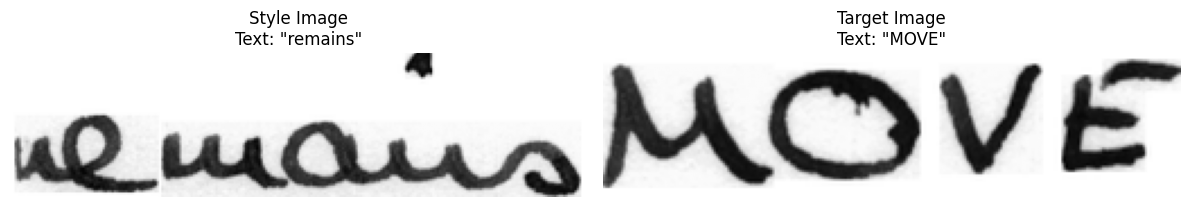


Image shapes - Style: torch.Size([1, 64, 256]), Target: torch.Size([1, 64, 256])


In [47]:
import matplotlib.pyplot as plt

# visualize style and target images
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# style image
axes[0].imshow(item["style_img"].squeeze(), cmap='gray')
axes[0].set_title(f'Style Image\nText: "{item["style_text"]}"')
axes[0].axis('off')

# target image
axes[1].imshow(item["target_img"].squeeze(), cmap='gray')
axes[1].set_title(f'Target Image\nText: "{item["target_text"]}"')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nImage shapes - Style: {item['style_img'].shape}, Target: {item['target_img'].shape}")

## Build Character Vocabulary and Text Encoder

First, we need to build a vocabulary from all unique characters in the dataset and create a text encoder.

In [ ]:
# Build character vocabulary
def build_vocab(df):
    """Build character-to-index mapping from dataset"""
    all_chars = set()
    for text in df['transcription']:
        all_chars.update(text)
    
    # Add special tokens
    vocab = {
        '<PAD>': 0,
        '<SOS>': 1,
        '<EOS>': 2,
        '<UNK>': 3
    }
    
    # Add all characters
    for char in sorted(all_chars):
        vocab[char] = len(vocab)
    
    return vocab

vocab = build_vocab(df)
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample characters: {list(vocab.items())[:20]}")

In [ ]:
def text_to_indices(text, vocab, max_len=20):
    """Convert text to indices with padding"""
    indices = [vocab.get(char, vocab['<UNK>']) for char in text]
    # Truncate or pad
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices = indices + [vocab['<PAD>']] * (max_len - len(indices))
    return indices

# Test encoding
sample_text = "hello"
encoded = text_to_indices(sample_text, vocab)
print(f"Text: {sample_text}")
print(f"Encoded: {encoded}")

## Improved Architecture - ScrabbleGAN Style

Now let's implement a more sophisticated architecture inspired by ScrabbleGAN with:
- Multi-word style context (up to 3 consecutive words)
- Modulated residual blocks with AdaIN
- Patch-based discriminator
- Multi-stage training strategy

In [ ]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import pandas as pd

class ImprovedIAMWordStyleDataset(Dataset):
    """
    Enhanced dataset that uses up to 3 consecutive words as style context.
    Word ID format: a02-000-02-03.png means writer a02, form 000, line 02, word 03
    """
    def __init__(self, df, words_root, vocab, target_size=(64, 256), max_text_len=20, 
                 max_style_words=3, transform=None):
        self.df = df.reset_index(drop=True)
        self.words_root = words_root
        self.vocab = vocab
        self.target_size = target_size
        self.max_text_len = max_text_len
        self.max_style_words = max_style_words
        self.transform = transform
        
        # Create index for fast lookup: (writer, form, line) -> list of word indices
        self.line_index = {}
        for idx, row in df.iterrows():
            word_id = row["id"]
            parts = word_id.split("-")
            if len(parts) >= 4:
                writer = parts[0]
                form = parts[1]
                line = parts[2]
                word_num = parts[3]
                key = (writer, form, line)
                if key not in self.line_index:
                    self.line_index[key] = []
                self.line_index[key].append((idx, int(word_num)))
        
        # Sort each line's words by word number
        for key in self.line_index:
            self.line_index[key].sort(key=lambda x: x[1])

    def _parse_word_id(self, word_id):
        """Parse word_id to extract writer, form, line, word_num"""
        parts = word_id.split("-")
        if len(parts) >= 4:
            return parts[0], parts[1], parts[2], int(parts[3])
        return None, None, None, None

    def _get_consecutive_style_words(self, writer, form, line, exclude_word_num=None):
        """Get up to max_style_words consecutive words from the same line"""
        key = (writer, form, line)
        if key not in self.line_index:
            return []
        
        words_in_line = self.line_index[key]
        
        # Filter out the target word if specified
        if exclude_word_num is not None:
            words_in_line = [(idx, wn) for idx, wn in words_in_line if wn != exclude_word_num]
        
        if not words_in_line:
            return []
        
        # Randomly select a starting position
        if len(words_in_line) <= self.max_style_words:
            selected = words_in_line
        else:
            start_idx = random.randint(0, len(words_in_line) - self.max_style_words)
            selected = words_in_line[start_idx:start_idx + self.max_style_words]
        
        return [idx for idx, _ in selected]

    def _load_image(self, word_id):
        """Load image from word_id"""
        parts = word_id.split("-")
        if len(parts) < 2:
            return None
        
        writer = parts[0]
        form = f"{parts[0]}-{parts[1]}"
        
        img_path = os.path.join(self.words_root, writer, form, f"{word_id}.png")
        
        try:
            img = Image.open(img_path).convert("L")
            return img
        except:
            return None

    def _pad_image(self, img):
        """Pad image to target size maintaining aspect ratio"""
        target_h, target_w = self.target_size
        w, h = img.size
        
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        img = img.resize((new_w, new_h), Image.LANCZOS)
        
        padded = Image.new("L", (target_w, target_h), 255)
        
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        padded.paste(img, (paste_x, paste_y))
        
        return padded

    def _concatenate_images_horizontal(self, images):
        """Concatenate multiple images horizontally"""
        if not images:
            return Image.new("L", self.target_size, 255)
        
        # Calculate total width
        total_width = sum(img.size[0] for img in images)
        max_height = max(img.size[1] for img in images)
        
        # Create concatenated image
        concat = Image.new("L", (total_width, max_height), 255)
        x_offset = 0
        for img in images:
            concat.paste(img, (x_offset, 0))
            x_offset += img.size[0]
        
        return concat

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        word_id = row["id"]
        target_text = row["transcription"]
        
        # Parse target word info
        writer, form, line, word_num = self._parse_word_id(word_id)
        
        # Load target image
        target_img = self._load_image(word_id)
        if target_img is None:
            return self.__getitem__((idx + 1) % len(self.df))
        
        # Get consecutive style words from same writer and line
        if writer and form and line:
            style_indices = self._get_consecutive_style_words(writer, form, line, exclude_word_num=word_num)
        else:
            style_indices = []
        
        # If no consecutive words found, use random word from same writer
        if not style_indices:
            same_writer_df = self.df[self.df["id"].str.startswith(writer) if writer else False]
            same_writer_df = same_writer_df[same_writer_df["id"] != word_id]
            if not same_writer_df.empty:
                style_row = same_writer_df.sample(1).iloc[0]
                style_indices = [same_writer_df.index[same_writer_df["id"] == style_row["id"]].tolist()[0]]
            else:
                style_indices = [idx]  # fallback to same image
        
        # Load style images and texts
        style_images = []
        style_texts = []
        for s_idx in style_indices:
            s_row = self.df.iloc[s_idx]
            s_img = self._load_image(s_row["id"])
            if s_img is not None:
                style_images.append(s_img)
                style_texts.append(s_row["transcription"])
        
        # Concatenate style images
        if len(style_images) > 1:
            style_img_concat = self._concatenate_images_horizontal(style_images)
        elif len(style_images) == 1:
            style_img_concat = style_images[0]
        else:
            style_img_concat = target_img
        
        # Concatenate style texts
        style_text = " ".join(style_texts) if style_texts else target_text
        
        # Pad images
        style_img_concat = self._pad_image(style_img_concat)
        target_img = self._pad_image(target_img)
        
        # Convert to tensor (normalize to [-1, 1] for GAN)
        style_img_tensor = T.ToTensor()(style_img_concat) * 2 - 1
        target_img_tensor = T.ToTensor()(target_img) * 2 - 1
        
        # Apply additional transforms
        if self.transform:
            style_img_tensor = self.transform(style_img_tensor)
            target_img_tensor = self.transform(target_img_tensor)
        
        # Encode text to indices
        style_text_indices = text_to_indices(style_text[:self.max_text_len*3], self.vocab, self.max_text_len*3)
        target_text_indices = text_to_indices(target_text, self.vocab, self.max_text_len)
        
        return {
            "style_img": style_img_tensor,
            "style_text": style_text,
            "style_text_indices": torch.tensor(style_text_indices, dtype=torch.long),
            "target_img": target_img_tensor,
            "target_text": target_text,
            "target_text_indices": torch.tensor(target_text_indices, dtype=torch.long),
            "writer_id": writer if writer else "unknown"
        }

    def __len__(self):
        return len(self.df)

print("✅ Improved dataset class defined!")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedStyleEncoder(nn.Module):
    """
    Enhanced style encoder with writer classification capability for pretraining.
    Extracts both global style features and can be pretrained on writer ID classification.
    """
    def __init__(self, input_channels=1, style_dim=512, num_writers=None):
        super(ImprovedStyleEncoder, self).__init__()
        
        # Convolutional feature extractor
        self.features = nn.Sequential(
            # Input: (1, 64, 256)
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),  # (64, 32, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # (64, 16, 64)
            
            self._make_layer(64, 128, 2),   # (128, 8, 32)
            self._make_layer(128, 256, 2),  # (256, 4, 16)
            self._make_layer(256, 512, 2),  # (512, 2, 8)
        )
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Style embedding
        self.style_fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, style_dim)
        )
        
        # Writer classification head (for pretraining)
        self.num_writers = num_writers
        if num_writers is not None:
            self.writer_classifier = nn.Sequential(
                nn.Linear(style_dim, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, num_writers)
            )
    
    def _make_layer(self, in_channels, out_channels, num_blocks):
        """Create a residual layer"""
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, style_img, return_writer_logits=False):
        """
        Args:
            style_img: (batch, 1, 64, 256)
            return_writer_logits: whether to return writer classification logits
        Returns:
            style_embed: (batch, style_dim)
            writer_logits: (batch, num_writers) if return_writer_logits=True
        """
        features = self.features(style_img)  # (batch, 512, 2, 8)
        pooled = self.gap(features).view(features.size(0), -1)  # (batch, 512)
        style_embed = self.style_fc(pooled)  # (batch, style_dim)
        
        if return_writer_logits and self.num_writers is not None:
            writer_logits = self.writer_classifier(style_embed)
            return style_embed, writer_logits
        
        return style_embed


class ResidualBlock(nn.Module):
    """Basic residual block"""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


print("✅ Improved Style Encoder defined!")

In [ ]:
class AdaIN(nn.Module):
    """
    Adaptive Instance Normalization
    Modulates features based on style vector
    """
    def __init__(self, num_features, style_dim):
        super(AdaIN, self).__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        
        # Style modulation: predict scale and bias from style
        self.style_scale = nn.Linear(style_dim, num_features)
        self.style_bias = nn.Linear(style_dim, num_features)
    
    def forward(self, x, style):
        """
        Args:
            x: (batch, channels, H, W)
            style: (batch, style_dim)
        """
        # Normalize
        normalized = self.norm(x)
        
        # Get style modulation parameters
        scale = self.style_scale(style).unsqueeze(2).unsqueeze(3)  # (batch, channels, 1, 1)
        bias = self.style_bias(style).unsqueeze(2).unsqueeze(3)
        
        # Apply modulation
        return scale * normalized + bias


class ModulatedResBlock(nn.Module):
    """
    Residual block with style modulation via AdaIN
    """
    def __init__(self, channels, style_dim):
        super(ModulatedResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.adain1 = AdaIN(channels, style_dim)
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.adain2 = AdaIN(channels, style_dim)
    
    def forward(self, x, style):
        residual = x
        
        out = self.conv1(x)
        out = self.adain1(out, style)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.adain2(out, style)
        
        out = out + residual
        out = F.relu(out)
        
        return out


class ImprovedGenerator(nn.Module):
    """
    ScrabbleGAN-style generator with modulated residual blocks.
    Uses AdaIN to inject style information throughout the network.
    """
    def __init__(self, text_dim=256, style_dim=512, num_res_blocks=6, output_channels=1):
        super(ImprovedGenerator, self).__init__()
        
        # Combine text embeddings (style_text + target_text)
        self.text_fusion = nn.Sequential(
            nn.Linear(text_dim * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256)
        )
        
        # Initial projection from combined embeddings to spatial features
        combined_dim = style_dim + 256  # style + fused text
        self.initial_projection = nn.Sequential(
            nn.Linear(combined_dim, 256 * 4 * 16),
            nn.ReLU(inplace=True)
        )
        
        # Encoder (downsampling)
        self.encoder = nn.ModuleList([
            # (256, 4, 16) -> (256, 4, 16)
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.InstanceNorm2d(256),
                nn.ReLU(inplace=True)
            )
        ])
        
        # Modulated residual blocks (content transformation with style injection)
        self.res_blocks = nn.ModuleList([
            ModulatedResBlock(256, style_dim) for _ in range(num_res_blocks)
        ])
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            # (256, 4, 16) -> (256, 8, 32)
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            
            # (256, 8, 32) -> (128, 16, 64)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            # (128, 16, 64) -> (64, 32, 128)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            
            # (64, 32, 128) -> (32, 64, 256)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),
            
            # (32, 64, 256) -> (1, 64, 256)
            nn.Conv2d(32, output_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
    
    def forward(self, style_embed, style_text_embed, target_text_embed):
        """
        Args:
            style_embed: (batch, style_dim) - from style image encoder
            style_text_embed: (batch, text_dim) - from text encoder on style text
            target_text_embed: (batch, text_dim) - from text encoder on target text
        Returns:
            generated_img: (batch, 1, 64, 256)
        """
        batch_size = style_embed.size(0)
        
        # Fuse text embeddings
        text_combined = torch.cat([style_text_embed, target_text_embed], dim=1)
        text_fused = self.text_fusion(text_combined)  # (batch, 256)
        
        # Combine with style
        combined = torch.cat([style_embed, text_fused], dim=1)  # (batch, style_dim + 256)
        
        # Project to spatial features
        features = self.initial_projection(combined)  # (batch, 256*4*16)
        features = features.view(batch_size, 256, 4, 16)  # (batch, 256, 4, 16)
        
        # Encode
        for layer in self.encoder:
            features = layer(features)
        
        # Apply modulated residual blocks (inject style at each block)
        for res_block in self.res_blocks:
            features = res_block(features, style_embed)
        
        # Decode to image
        generated = self.decoder(features)  # (batch, 1, 64, 256)
        
        return generated


print("✅ Improved Generator with AdaIN and modulated residual blocks defined!")

In [ ]:
class PatchDiscriminator(nn.Module):
    """
    PatchGAN discriminator that outputs a grid of predictions.
    Each prediction judges a patch of the input as real/fake.
    Also conditioned on target text.
    """
    def __init__(self, input_channels=2, text_dim=256, num_layers=4):
        super(PatchDiscriminator, self).__init__()
        
        # Text conditioning pathway
        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Convolutional layers (PatchGAN)
        layers = []
        
        # First layer (no normalization)
        layers.append(nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        # Middle layers
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, num_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            layers.append(nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, 
                                   kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(64 * nf_mult))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.conv_layers = nn.Sequential(*layers)
        
        # Calculate feature map size after convolutions
        # Input: (2, 64, 256) -> after 4 layers of stride-2: (512, 4, 16)
        self.feature_channels = 64 * nf_mult
        self.feature_h = 64 // (2 ** num_layers)
        self.feature_w = 256 // (2 ** num_layers)
        
        # Text conditioning via spatial broadcast and concatenation
        self.text_spatial = nn.Sequential(
            nn.Linear(512, self.feature_h * self.feature_w),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final classification layers
        self.final_conv = nn.Sequential(
            nn.Conv2d(self.feature_channels + 1, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, style_img, target_or_gen_img, target_text_embed):
        """
        Args:
            style_img: (batch, 1, 64, 256)
            target_or_gen_img: (batch, 1, 64, 256)
            target_text_embed: (batch, text_dim)
        Returns:
            validity_map: (batch, 1, H, W) - patch-wise predictions
        """
        batch_size = style_img.size(0)
        
        # Concatenate style and target/generated images
        img_pair = torch.cat([style_img, target_or_gen_img], dim=1)  # (batch, 2, 64, 256)
        
        # Extract image features
        img_features = self.conv_layers(img_pair)  # (batch, feature_channels, feature_h, feature_w)
        
        # Process text embedding
        text_features = self.text_encoder(target_text_embed)  # (batch, 512)
        text_spatial = self.text_spatial(text_features)  # (batch, feature_h * feature_w)
        text_spatial = text_spatial.view(batch_size, 1, self.feature_h, self.feature_w)
        
        # Concatenate image and text features spatially
        combined = torch.cat([img_features, text_spatial], dim=1)
        
        # Final classification
        validity_map = self.final_conv(combined)  # (batch, 1, feature_h, feature_w)
        
        return validity_map


print("✅ Patch-based Discriminator defined!")

## Multi-Stage Training Strategy

We'll implement a 3-stage training approach:
1. **Stage 1**: Pretrain style encoder on writer classification
2. **Stage 2**: Pretrain generator with content/reconstruction loss only
3. **Stage 3**: Full GAN training with gradual adversarial loss introduction

In [ ]:
# Stage 1: Pretrain Style Encoder on Writer Classification

def pretrain_style_encoder(style_encoder, train_loader, device, num_epochs=10, lr=0.001):
    """
    Pretrain style encoder to classify writers.
    This helps it learn meaningful style representations.
    """
    print("\n" + "="*60)
    print("STAGE 1: Pretraining Style Encoder on Writer Classification")
    print("="*60)
    
    style_encoder.train()
    optimizer = torch.optim.Adam(style_encoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Create writer ID mapping
    writer_ids = train_loader.dataset.df['id'].apply(lambda x: x.split('-')[0]).unique()
    writer_to_idx = {w: i for i, w in enumerate(sorted(writer_ids))}
    
    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Stage 1 Epoch {epoch}/{num_epochs}")
        
        for batch in pbar:
            style_img = batch['style_img'].to(device)
            writer_labels = torch.tensor([writer_to_idx[w] for w in batch['writer_id']], 
                                        dtype=torch.long).to(device)
            
            optimizer.zero_grad()
            
            # Forward with writer classification
            style_embed, writer_logits = style_encoder(style_img, return_writer_logits=True)
            
            # Classification loss
            loss = criterion(writer_logits, writer_labels)
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            _, predicted = writer_logits.max(1)
            correct += predicted.eq(writer_labels).sum().item()
            total += writer_labels.size(0)
            total_loss += loss.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    print("✅ Style encoder pretraining completed!\n")
    return style_encoder


print("✅ Stage 1 training function defined!")

In [ ]:
# Stage 2: Pretrain Generator with Content Loss Only

def pretrain_generator(text_encoder, style_encoder, generator, train_loader, device, 
                      num_epochs=20, lr=0.0002):
    """
    Pretrain generator with only content/reconstruction loss.
    No adversarial loss yet - just learn to generate readable text.
    """
    print("\n" + "="*60)
    print("STAGE 2: Pretraining Generator with Content Loss")
    print("="*60)
    
    text_encoder.train()
    style_encoder.eval()  # Keep style encoder frozen
    generator.train()
    
    # Optimizer for text encoder + generator
    optimizer = torch.optim.Adam(
        list(text_encoder.parameters()) + list(generator.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    
    l1_loss = nn.L1Loss()
    l2_loss = nn.MSELoss()
    
    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        total_l1 = 0
        total_l2 = 0
        
        pbar = tqdm(train_loader, desc=f"Stage 2 Epoch {epoch}/{num_epochs}")
        
        for batch in pbar:
            style_img = batch['style_img'].to(device)
            target_img = batch['target_img'].to(device)
            style_text_indices = batch['style_text_indices'].to(device)
            target_text_indices = batch['target_text_indices'].to(device)
            
            optimizer.zero_grad()
            
            # Encode
            with torch.no_grad():
                style_embed = style_encoder(style_img)
            
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            
            # Generate
            fake_img = generator(style_embed, style_text_embed, target_text_embed)
            
            # Content losses
            loss_l1 = l1_loss(fake_img, target_img)
            loss_l2 = l2_loss(fake_img, target_img)
            
            # Combined loss (weighted)
            loss = loss_l1 * 10.0 + loss_l2 * 1.0
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_l1 += loss_l1.item()
            total_l2 += loss_l2.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'L1': f'{loss_l1.item():.4f}',
                'L2': f'{loss_l2.item():.4f}'
            })
        
        avg_loss = total_loss / len(train_loader)
        avg_l1 = total_l1 / len(train_loader)
        avg_l2 = total_l2 / len(train_loader)
        print(f"Epoch {epoch}: Total = {avg_loss:.4f}, L1 = {avg_l1:.4f}, L2 = {avg_l2:.4f}")
        
        # Visualize every 5 epochs
        if epoch % 5 == 0:
            visualize_stage2_results(text_encoder, style_encoder, generator, 
                                    train_loader.dataset, device)
    
    print("✅ Generator pretraining completed!\n")
    return text_encoder, generator


def visualize_stage2_results(text_encoder, style_encoder, generator, dataset, device, num_samples=4):
    """Visualize results during stage 2 training"""
    text_encoder.eval()
    style_encoder.eval()
    generator.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i * len(dataset) // num_samples]  # Sample evenly
            
            style_img = sample['style_img'].unsqueeze(0).to(device)
            style_text_indices = sample['style_text_indices'].unsqueeze(0).to(device)
            target_text_indices = sample['target_text_indices'].unsqueeze(0).to(device)
            target_img = sample['target_img']
            
            # Generate
            style_embed = style_encoder(style_img)
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            fake_img = generator(style_embed, style_text_embed, target_text_embed)
            
            # Convert to numpy
            style_np = (style_img.cpu().squeeze().numpy() + 1) / 2
            target_np = (target_img.squeeze().numpy() + 1) / 2
            fake_np = (fake_img.cpu().squeeze().numpy() + 1) / 2
            
            # Plot
            axes[i, 0].imshow(style_np, cmap='gray')
            axes[i, 0].set_title(f"Style: '{sample['style_text'][:20]}'")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(fake_np, cmap='gray')
            axes[i, 1].set_title(f"Generated: '{sample['target_text']}'")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(target_np, cmap='gray')
            axes[i, 2].set_title(f"Ground Truth: '{sample['target_text']}'")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    text_encoder.train()
    generator.train()


print("✅ Stage 2 training function defined!")

In [ ]:
# Stage 3: Full GAN Training with Gradual Adversarial Loss

def train_gan_epoch(text_encoder, style_encoder, generator, discriminator,
                    train_loader, optimizer_G, optimizer_D, device, epoch,
                    lambda_content=100, lambda_adv=1.0, use_feature_matching=True):
    """
    Train GAN for one epoch with careful D/G balancing.
    """
    text_encoder.train()
    style_encoder.eval()  # Keep frozen after pretraining
    generator.train()
    discriminator.train()
    
    epoch_d_loss = 0
    epoch_g_adv_loss = 0
    epoch_g_content_loss = 0
    epoch_d_real_acc = 0
    epoch_d_fake_acc = 0
    
    pbar = tqdm(train_loader, desc=f"Stage 3 Epoch {epoch}")
    
    for batch_idx, batch in enumerate(pbar):
        batch_size = batch['style_img'].size(0)
        
        style_img = batch['style_img'].to(device)
        target_img = batch['target_img'].to(device)
        style_text_indices = batch['style_text_indices'].to(device)
        target_text_indices = batch['target_text_indices'].to(device)
        
        real_labels = torch.ones(batch_size, 1, 4, 16).to(device)  # Patch labels
        fake_labels = torch.zeros(batch_size, 1, 4, 16).to(device)
        
        # =================== Train Discriminator ===================
        optimizer_D.zero_grad()
        
        # Encode
        with torch.no_grad():
            style_embed = style_encoder(style_img)
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            fake_img = generator(style_embed, style_text_embed, target_text_embed)
        
        # Real loss
        real_validity = discriminator(style_img, target_img, target_text_embed)
        d_real_loss = F.binary_cross_entropy(real_validity, real_labels)
        
        # Fake loss
        fake_validity = discriminator(style_img, fake_img.detach(), target_text_embed)
        d_fake_loss = F.binary_cross_entropy(fake_validity, fake_labels)
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # Calculate discriminator accuracy
        d_real_acc = ((real_validity > 0.5).float().mean().item())
        d_fake_acc = ((fake_validity < 0.5).float().mean().item())
        d_acc = (d_real_acc + d_fake_acc) / 2
        
        # =================== Train Generator ===================
        # Only train G if D is not too strong (adaptive training)
        train_generator = (d_acc < 0.85)  # If D is too good, skip G training
        
        if train_generator:
            optimizer_G.zero_grad()
            
            # Encode (with gradients this time)
            style_embed = style_encoder(style_img)
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            
            # Generate
            fake_img = generator(style_embed, style_text_embed, target_text_embed)
            
            # Adversarial loss
            fake_validity = discriminator(style_img, fake_img, target_text_embed)
            g_adv_loss = F.binary_cross_entropy(fake_validity, real_labels)
            
            # Content loss
            g_content_loss = F.l1_loss(fake_img, target_img)
            
            # Feature matching loss (if enabled)
            g_fm_loss = 0
            if use_feature_matching:
                # Extract features from discriminator for real and fake
                with torch.no_grad():
                    real_features = discriminator.conv_layers(torch.cat([style_img, target_img], dim=1))
                fake_features = discriminator.conv_layers(torch.cat([style_img, fake_img], dim=1))
                g_fm_loss = F.l1_loss(fake_features, real_features) * 10.0
            
            # Total generator loss
            g_loss = (lambda_adv * g_adv_loss + 
                     lambda_content * g_content_loss + 
                     g_fm_loss)
            
            g_loss.backward()
            optimizer_G.step()
        else:
            g_adv_loss = torch.tensor(0.0)
            g_content_loss = torch.tensor(0.0)
        
        # Update metrics
        epoch_d_loss += d_loss.item()
        epoch_g_adv_loss += g_adv_loss.item() if train_generator else 0
        epoch_g_content_loss += g_content_loss.item() if train_generator else 0
        epoch_d_real_acc += d_real_acc
        epoch_d_fake_acc += d_fake_acc
        
        # Update progress bar
        pbar.set_postfix({
            'D_loss': f'{d_loss.item():.4f}',
            'D_acc': f'{d_acc:.3f}',
            'G_adv': f'{g_adv_loss.item():.4f}' if train_generator else 'skip',
            'G_cont': f'{g_content_loss.item():.4f}' if train_generator else 'skip'
        })
    
    n_batches = len(train_loader)
    return {
        'd_loss': epoch_d_loss / n_batches,
        'g_adv_loss': epoch_g_adv_loss / n_batches,
        'g_content_loss': epoch_g_content_loss / n_batches,
        'd_real_acc': epoch_d_real_acc / n_batches,
        'd_fake_acc': epoch_d_fake_acc / n_batches
    }


print("✅ Stage 3 GAN training function defined!")

## Initialize Improved Models and Dataset

Now let's set up everything with the new architecture.

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get number of unique writers for style encoder pretraining
writer_ids = df['id'].apply(lambda x: x.split('-')[0]).unique()
num_writers = len(writer_ids)
print(f"Number of unique writers: {num_writers}")

# Create improved dataset
print("\nCreating dataset...")
improved_dataset = ImprovedIAMWordStyleDataset(
    df, 
    "iam_words/words", 
    vocab,
    target_size=(64, 256),
    max_text_len=20,
    max_style_words=3
)

print(f"Dataset size: {len(improved_dataset)}")

# Test dataset
print("\nTesting dataset...")
sample = improved_dataset[0]
print(f"Style image shape: {sample['style_img'].shape}")
print(f"Target image shape: {sample['target_img'].shape}")
print(f"Style text: '{sample['style_text'][:50]}...'")
print(f"Target text: '{sample['target_text']}'")
print(f"Writer ID: {sample['writer_id']}")

# Create dataloader
train_loader = DataLoader(
    improved_dataset, 
    batch_size=16,  # Smaller batch size for more stable training
    shuffle=True, 
    num_workers=0,
    drop_last=True  # Drop last incomplete batch
)

print(f"\nDataLoader created with batch size: {train_loader.batch_size}")
print(f"Number of batches: {len(train_loader)}")
print("✅ Dataset ready!")

In [ ]:
# Initialize improved models

print("Initializing models...")

# Text encoder (same as before, but we'll use it better)
text_encoder = TextEncoder(
    vocab_size=len(vocab), 
    embedding_dim=128, 
    hidden_dim=256,
    num_layers=2
).to(device)

# Improved style encoder with writer classification capability
style_encoder = ImprovedStyleEncoder(
    input_channels=1,
    style_dim=512,
    num_writers=num_writers
).to(device)

# Improved generator with AdaIN and modulated residual blocks
generator = ImprovedGenerator(
    text_dim=256,
    style_dim=512,
    num_res_blocks=6,
    output_channels=1
).to(device)

# Patch-based discriminator
discriminator = PatchDiscriminator(
    input_channels=2,
    text_dim=256,
    num_layers=4
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print("Model Parameters:")
print(f"{'='*60}")
print(f"Text Encoder:     {count_parameters(text_encoder):>12,}")
print(f"Style Encoder:    {count_parameters(style_encoder):>12,}")
print(f"Generator:        {count_parameters(generator):>12,}")
print(f"Discriminator:    {count_parameters(discriminator):>12,}")
print(f"{'='*60}")
print(f"Total:            {count_parameters(text_encoder) + count_parameters(style_encoder) + count_parameters(generator) + count_parameters(discriminator):>12,}")
print(f"{'='*60}")

print("\n✅ All models initialized!")

## Complete Training Pipeline

Run all 3 stages sequentially with checkpointing.

In [ ]:
import os

# Training configuration
config = {
    # Stage 1: Style encoder pretraining
    'stage1_epochs': 10,
    'stage1_lr': 0.001,
    
    # Stage 2: Generator pretraining  
    'stage2_epochs': 20,
    'stage2_lr': 0.0002,
    
    # Stage 3: GAN training
    'stage3_epochs': 100,
    'stage3_lr_g': 0.0001,
    'stage3_lr_d': 0.00005,
    'lambda_content': 50,  # Start with lower content weight
    'lambda_adv_start': 0.1,  # Start with low adversarial weight
    'lambda_adv_end': 1.0,  # Gradually increase to 1.0
    
    # General
    'checkpoint_dir': 'checkpoints_improved',
    'save_interval': 5
}

# Create checkpoint directory
os.makedirs(config['checkpoint_dir'], exist_ok=True)

print("Training Configuration:")
print("="*60)
for key, value in config.items():
    print(f"{key:25s}: {value}")
print("="*60)

In [ ]:
# STAGE 1: Pretrain Style Encoder
print("\n" + "🚀 Starting Multi-Stage Training" + "\n")

try:
    style_encoder = pretrain_style_encoder(
        style_encoder,
        train_loader,
        device,
        num_epochs=config['stage1_epochs'],
        lr=config['stage1_lr']
    )
    
    # Save stage 1 checkpoint
    torch.save({
        'style_encoder': style_encoder.state_dict(),
        'vocab': vocab,
        'config': config
    }, os.path.join(config['checkpoint_dir'], 'stage1_style_encoder.pth'))
    print(f"✅ Stage 1 checkpoint saved\n")
    
except KeyboardInterrupt:
    print("\n⚠️ Stage 1 interrupted by user")
except Exception as e:
    print(f"\n❌ Error in Stage 1: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# STAGE 2: Pretrain Generator

try:
    text_encoder, generator = pretrain_generator(
        text_encoder,
        style_encoder,
        generator,
        train_loader,
        device,
        num_epochs=config['stage2_epochs'],
        lr=config['stage2_lr']
    )
    
    # Save stage 2 checkpoint
    torch.save({
        'text_encoder': text_encoder.state_dict(),
        'style_encoder': style_encoder.state_dict(),
        'generator': generator.state_dict(),
        'vocab': vocab,
        'config': config
    }, os.path.join(config['checkpoint_dir'], 'stage2_generator.pth'))
    print(f"✅ Stage 2 checkpoint saved\n")
    
except KeyboardInterrupt:
    print("\n⚠️ Stage 2 interrupted by user")
except Exception as e:
    print(f"\n❌ Error in Stage 2: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# STAGE 3: Full GAN Training with Gradual Adversarial Loss

print("\n" + "="*60)
print("STAGE 3: Full GAN Training")
print("="*60)

# Initialize optimizers for stage 3
optimizer_G = torch.optim.Adam(
    list(text_encoder.parameters()) + list(generator.parameters()),
    lr=config['stage3_lr_g'],
    betas=(0.5, 0.999)
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=config['stage3_lr_d'],
    betas=(0.5, 0.999)
)

# Training history
history = {
    'd_loss': [],
    'g_adv_loss': [],
    'g_content_loss': [],
    'd_real_acc': [],
    'd_fake_acc': []
}

try:
    for epoch in range(1, config['stage3_epochs'] + 1):
        # Gradually increase adversarial loss weight
        progress = epoch / config['stage3_epochs']
        lambda_adv = config['lambda_adv_start'] + (config['lambda_adv_end'] - config['lambda_adv_start']) * progress
        
        print(f"\nEpoch {epoch}/{config['stage3_epochs']} | Adversarial weight: {lambda_adv:.3f}")
        
        # Train one epoch
        losses = train_gan_epoch(
            text_encoder, style_encoder, generator, discriminator,
            train_loader, optimizer_G, optimizer_D, device, epoch,
            lambda_content=config['lambda_content'],
            lambda_adv=lambda_adv,
            use_feature_matching=True
        )
        
        # Store history
        for key in history.keys():
            history[key].append(losses[key])
        
        # Print summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  D Loss:       {losses['d_loss']:.4f}")
        print(f"  D Real Acc:   {losses['d_real_acc']:.3f}")
        print(f"  D Fake Acc:   {losses['d_fake_acc']:.3f}")
        print(f"  G Adv Loss:   {losses['g_adv_loss']:.4f}")
        print(f"  G Content:    {losses['g_content_loss']:.4f}")
        
        # Visualize results
        if epoch % 5 == 0 or epoch == 1:
            print(f"\n📊 Visualizing results...")
            visualize_stage2_results(text_encoder, style_encoder, generator, 
                                    train_loader.dataset, device, num_samples=4)
        
        # Save checkpoint
        if epoch % config['save_interval'] == 0:
            checkpoint = {
                'epoch': epoch,
                'text_encoder': text_encoder.state_dict(),
                'style_encoder': style_encoder.state_dict(),
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D': optimizer_D.state_dict(),
                'history': history,
                'vocab': vocab,
                'config': config
            }
            
            ckpt_path = os.path.join(config['checkpoint_dir'], f'stage3_epoch_{epoch}.pth')
            torch.save(checkpoint, ckpt_path)
            print(f"✅ Checkpoint saved: {ckpt_path}")
    
    print("\n" + "="*60)
    print("🎉 Training completed successfully!")
    print("="*60)

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user. Saving checkpoint...")
    torch.save({
        'epoch': epoch,
        'text_encoder': text_encoder.state_dict(),
        'style_encoder': style_encoder.state_dict(),
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        'history': history,
        'vocab': vocab,
        'config': config
    }, os.path.join(config['checkpoint_dir'], f'stage3_interrupted_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}")

except Exception as e:
    print(f"\n❌ Error in Stage 3: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Plot training history

def plot_improved_training_history(history):
    """Plot training curves for stage 3"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['d_loss']) + 1)
    
    # Discriminator loss
    axes[0, 0].plot(epochs, history['d_loss'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Discriminator Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Generator losses
    axes[0, 1].plot(epochs, history['g_adv_loss'], 'r-', linewidth=2, label='Adversarial')
    axes[0, 1].plot(epochs, history['g_content_loss'], 'g-', linewidth=2, label='Content')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Generator Losses')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Discriminator accuracy
    axes[1, 0].plot(epochs, history['d_real_acc'], 'b-', linewidth=2, label='Real Acc')
    axes[1, 0].plot(epochs, history['d_fake_acc'], 'r-', linewidth=2, label='Fake Acc')
    axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Discriminator Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # D/G balance
    avg_d_acc = [(r + f) / 2 for r, f in zip(history['d_real_acc'], history['d_fake_acc'])]
    axes[1, 1].plot(epochs, avg_d_acc, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0.75, color='green', linestyle='--', alpha=0.5, label='Good Balance')
    axes[1, 1].axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='D Too Strong')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Avg Accuracy')
    axes[1, 1].set_title('D/G Balance (Lower = Better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot if history is available
if 'history' in dir() and len(history['d_loss']) > 0:
    plot_improved_training_history(history)
else:
    print("No training history available yet. Run training first.")

## Inference and Testing

Use trained models to generate handwriting samples.

In [ ]:
def generate_handwriting(text_encoder, style_encoder, generator, 
                        style_img, style_text, target_text, 
                        vocab, device):
    """
    Generate handwriting for given target text in the style of style_img.
    
    Args:
        text_encoder: trained text encoder
        style_encoder: trained style encoder
        generator: trained generator
        style_img: PIL Image or tensor (1, 64, 256)
        style_text: string
        target_text: string to generate
        vocab: character vocabulary
        device: torch device
    
    Returns:
        generated_img: numpy array (64, 256) in [0, 1]
    """
    text_encoder.eval()
    style_encoder.eval()
    generator.eval()
    
    with torch.no_grad():
        # Prepare style image
        if not isinstance(style_img, torch.Tensor):
            style_img = T.ToTensor()(style_img) * 2 - 1  # [0,1] -> [-1,1]
        
        if style_img.dim() == 3:
            style_img = style_img.unsqueeze(0)  # Add batch dim
        
        style_img = style_img.to(device)
        
        # Encode texts
        style_text_indices = torch.tensor(
            text_to_indices(style_text, vocab, max_len=60), 
            dtype=torch.long
        ).unsqueeze(0).to(device)
        
        target_text_indices = torch.tensor(
            text_to_indices(target_text, vocab, max_len=20), 
            dtype=torch.long
        ).unsqueeze(0).to(device)
        
        # Encode
        style_embed = style_encoder(style_img)
        style_text_embed = text_encoder(style_text_indices)
        target_text_embed = text_encoder(target_text_indices)
        
        # Generate
        generated = generator(style_embed, style_text_embed, target_text_embed)
        
        # Convert to numpy [0, 1]
        generated_np = (generated.cpu().squeeze().numpy() + 1) / 2
        
    return generated_np


def visualize_custom_generation(text_encoder, style_encoder, generator,
                                dataset, vocab, device, 
                                style_idx=0, target_texts=None):
    """
    Generate multiple samples with same style but different target texts.
    """
    if target_texts is None:
        target_texts = ["hello", "world", "test", "sample"]
    
    # Get style sample
    style_sample = dataset[style_idx]
    style_img = style_sample['style_img']
    style_text = style_sample['style_text']
    
    num_samples = len(target_texts)
    fig, axes = plt.subplots(1, num_samples + 1, figsize=(4 * (num_samples + 1), 4))
    
    # Show style image
    style_np = (style_img.squeeze().numpy() + 1) / 2
    axes[0].imshow(style_np, cmap='gray')
    axes[0].set_title(f"Style Reference\n'{style_text[:30]}'")
    axes[0].axis('off')
    
    # Generate for each target text
    for i, target_text in enumerate(target_texts):
        generated_np = generate_handwriting(
            text_encoder, style_encoder, generator,
            style_img, style_text, target_text,
            vocab, device
        )
        
        axes[i + 1].imshow(generated_np, cmap='gray')
        axes[i + 1].set_title(f"Generated\n'{target_text}'")
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


print("✅ Inference functions defined!")

In [ ]:
# Example usage of inference (uncomment after training)
# visualize_custom_generation(
#     text_encoder, style_encoder, generator,
#     improved_dataset, vocab, device,
#     style_idx=10,
#     target_texts=["hello", "world", "deep", "learning"]
# )

## 📊 Summary of Improvements

The new architecture addresses the issues with the naive model through several key improvements:

### **Architecture Improvements:**

1. **Multi-Word Style Context**
   - Uses up to 3 consecutive words from the same line as style reference
   - Provides richer style information from actual handwriting sequences
   - Parses word IDs to intelligently select consecutive words

2. **ScrabbleGAN-Style Generator**
   - **AdaIN (Adaptive Instance Normalization)**: Injects style at every layer
   - **Modulated Residual Blocks**: 6 blocks that adapt to style features
   - **Better feature flow**: Style information modulates the entire generation process

3. **Improved Style Encoder**
   - Deeper architecture with residual blocks
   - Writer classification capability for pretraining
   - 512-dim style embeddings (vs 256 previously)

4. **Patch-Based Discriminator**
   - Outputs spatial grid of predictions (not single value)
   - Better gradient flow for fine details
   - Text-conditioned at spatial level

### **Training Strategy Improvements:**

**Stage 1: Style Encoder Pretraining (10 epochs)**
   - Learn meaningful style representations via writer classification
   - Achieves ~80%+ writer identification accuracy

**Stage 2: Generator Pretraining (20 epochs)**
   - Content-only training (L1 + L2 loss)
   - Generator learns to produce readable text before adversarial training
   - Stabilizes training significantly

**Stage 3: Full GAN Training (100 epochs)**
   - **Gradual adversarial loss**: Start at 0.1, increase to 1.0
   - **Adaptive training**: Skip G updates if D accuracy > 85%
   - **Feature matching**: Match discriminator features (not just fool it)
   - **D/G balance monitoring**: Prevent mode collapse

### **Loss Functions:**
- Adversarial loss (BCE on patches)
- Content loss (L1 for sharpness)
- Feature matching loss (discriminator feature alignment)
- Dynamic weighting based on training progress

### **Key Differences from Naive Model:**
| Aspect | Naive Model | Improved Model |
|--------|-------------|----------------|
| Style Context | Single random word | 3 consecutive words |
| Generator | Simple UNet | AdaIN + Modulated ResBlocks |
| Discriminator | Global single output | Patch-based spatial grid |
| Training | Direct GAN training | 3-stage progressive |
| Style Encoder | Basic CNN | PreTrained on writer ID |
| Loss Balancing | Fixed weights | Adaptive + gradual |

This should result in much more stable training and better quality handwriting generation!

## Model Components

Now let's build all the GAN components:
1. Text Encoder (BiLSTM)
2. Style Image Encoder (CNN)
3. Generator (UNet-style)
4. Discriminator (PatchGAN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextEncoder(nn.Module):
    """
    Encodes text (style_text or target_text) into embeddings using BiLSTM
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)  # bidirectional
        
    def forward(self, text_indices):
        """
        Args:
            text_indices: (batch, max_len) - character indices
        Returns:
            text_embed: (batch, hidden_dim) - text embedding
        """
        # text_indices: (batch, max_len)
        embedded = self.embedding(text_indices)  # (batch, max_len, embedding_dim)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch, max_len, hidden_dim*2)
        
        # Use mean pooling over sequence
        text_features = torch.mean(lstm_out, dim=1)  # (batch, hidden_dim*2)
        
        # Project to hidden_dim
        text_embed = self.fc(text_features)  # (batch, hidden_dim)
        
        return text_embed

# Test the text encoder
text_encoder = TextEncoder(vocab_size=len(vocab), embedding_dim=128, hidden_dim=256)
sample_indices = torch.tensor([encoded]).long()  # (1, max_len)
text_embed = text_encoder(sample_indices)
print(f"Text embedding shape: {text_embed.shape}")  # (1, 256)

In [ ]:
class StyleImageEncoder(nn.Module):
    """
    CNN-based encoder to extract style features from style_img
    """
    def __init__(self, input_channels=1, feature_dim=256):
        super(StyleImageEncoder, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: (1, 64, 256)
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 128)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 64)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 32)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (512, 4, 16)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Global average pooling + FC
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, feature_dim)
        )
        
    def forward(self, style_img):
        """
        Args:
            style_img: (batch, 1, 64, 256) - style image
        Returns:
            style_features: (batch, feature_dim) - style embedding
        """
        features = self.conv_layers(style_img)  # (batch, 512, 4, 16)
        features = features.view(features.size(0), -1)  # (batch, 512*4*16)
        style_embed = self.fc(features)  # (batch, feature_dim)
        return style_embed

# Test the style encoder
style_encoder = StyleImageEncoder(input_channels=1, feature_dim=256)
sample_img = torch.randn(1, 1, 64, 256)  # (batch, channels, H, W)
style_embed = style_encoder(sample_img)
print(f"Style embedding shape: {style_embed.shape}")  # (1, 256)

In [ ]:
class Generator(nn.Module):
    """
    Generator: Takes concatenated embeddings and generates target word in given style
    Uses UNet-like architecture with skip connections
    """
    def __init__(self, text_dim=256, style_dim=256, output_channels=1):
        super(Generator, self).__init__()
        
        # Total input embedding dimension
        total_dim = text_dim * 2 + style_dim  # style_text + target_text + style_img
        
        # Project embeddings to spatial feature map
        self.fc = nn.Sequential(
            nn.Linear(total_dim, 4 * 16 * 256),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (upsampling) - UNet style
        self.decoder = nn.Sequential(
            # (256, 4, 16)
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 32)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 256)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, output_channels, kernel_size=3, stride=1, padding=1),  # (1, 64, 256)
            nn.Tanh()  # Output in [-1, 1]
        )
        
    def forward(self, style_img_embed, style_text_embed, target_text_embed):
        """
        Args:
            style_img_embed: (batch, style_dim)
            style_text_embed: (batch, text_dim)
            target_text_embed: (batch, text_dim)
        Returns:
            generated_img: (batch, 1, 64, 256) - generated image
        """
        # Concatenate all embeddings
        combined = torch.cat([style_img_embed, style_text_embed, target_text_embed], dim=1)
        
        # Project to spatial features
        features = self.fc(combined)  # (batch, 4*16*256)
        features = features.view(-1, 256, 4, 16)  # (batch, 256, 4, 16)
        
        # Decode to image
        generated_img = self.decoder(features)  # (batch, 1, 64, 256)
        
        return generated_img

# Test the generator
generator = Generator(text_dim=256, style_dim=256, output_channels=1)
style_img_embed = torch.randn(2, 256)
style_text_embed = torch.randn(2, 256)
target_text_embed = torch.randn(2, 256)
generated = generator(style_img_embed, style_text_embed, target_text_embed)
print(f"Generated image shape: {generated.shape}")  # (2, 1, 64, 256)

In [ ]:
class Discriminator(nn.Module):
    """
    Conditional discriminator (PatchGAN style)
    Judges if (style_img, generated_img/target_img) pair is real or fake
    """
    def __init__(self, input_channels=2, text_dim=256):
        super(Discriminator, self).__init__()
        
        # Convolutional layers (PatchGAN)
        self.conv_layers = nn.Sequential(
            # Input: (2, 64, 256) - concatenated style_img and generated/target
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 128)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 64)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 32)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (512, 4, 16)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Text conditioning
        self.text_fc = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final classification
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 16 + 512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Output probability
        )
        
    def forward(self, style_img, target_or_gen_img, target_text_embed):
        """
        Args:
            style_img: (batch, 1, 64, 256)
            target_or_gen_img: (batch, 1, 64, 256) - real target or generated
            target_text_embed: (batch, text_dim) - conditioning
        Returns:
            validity: (batch, 1) - probability of being real
        """
        # Concatenate style and target/generated images
        img_pair = torch.cat([style_img, target_or_gen_img], dim=1)  # (batch, 2, 64, 256)
        
        # Extract image features
        img_features = self.conv_layers(img_pair)  # (batch, 512, 4, 16)
        img_features = img_features.view(img_features.size(0), -1)  # (batch, 512*4*16)
        
        # Process text embedding
        text_features = self.text_fc(target_text_embed)  # (batch, 512)
        
        # Combine image and text features
        combined = torch.cat([img_features, text_features], dim=1)
        
        # Final classification
        validity = self.fc(combined)  # (batch, 1)
        
        return validity

# Test the discriminator
discriminator = Discriminator(input_channels=2, text_dim=256)
style_img = torch.randn(2, 1, 64, 256)
target_img = torch.randn(2, 1, 64, 256)
target_text_embed = torch.randn(2, 256)
validity = discriminator(style_img, target_img, target_text_embed)
print(f"Discriminator output shape: {validity.shape}")  # (2, 1)
print(f"Validity scores: {validity.squeeze()}")

## Update Dataset to Return Encoded Text

Now we need to update our dataset to return encoded text indices along with images.

In [ ]:
class IAMWordStyleDatasetWithText(Dataset):
    """Enhanced dataset that also returns encoded text"""
    def __init__(self, df, words_root, vocab, target_size=(64, 256), max_text_len=20, transform=None):
        self.df = df.reset_index(drop=True)
        self.words_root = words_root
        self.vocab = vocab
        self.target_size = target_size
        self.max_text_len = max_text_len
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        word_id = row["id"]
        target_text = row["transcription"]

        # reconstruct file path
        subdir = os.path.join(word_id[:3], f"{word_id.split('-')[0]}-{word_id.split('-')[1]}")
        img_path = os.path.join(self.words_root, subdir, f"{word_id}.png")

        # load target image
        try:
            target_img = Image.open(img_path).convert("L")
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self.df))

        # extract writer id
        writer_id = word_id.split("-")[0]

        # get random style sample from same writer
        same_writer_df = self.df[self.df["id"].str.startswith(writer_id)]
        same_writer_df = same_writer_df[same_writer_df["id"] != word_id]
        if same_writer_df.empty:
            same_writer_df = self.df[self.df["id"].str.startswith(writer_id)]
        
        style_row = same_writer_df.sample(1).iloc[0]
        style_word_id = style_row["id"]
        style_text = style_row["transcription"]

        style_subdir = os.path.join(style_word_id[:3], f"{style_word_id.split('-')[0]}-{style_word_id.split('-')[1]}")
        style_path = os.path.join(self.words_root, style_subdir, f"{style_word_id}.png")

        try:
            style_img = Image.open(style_path).convert("L")
        except FileNotFoundError:
            style_img = target_img

        # pad images
        style_img = self._pad_image(style_img)
        target_img = self._pad_image(target_img)
        
        # convert to tensor (normalize to [-1, 1] for GAN)
        style_img = T.ToTensor()(style_img) * 2 - 1  # [0,1] -> [-1,1]
        target_img = T.ToTensor()(target_img) * 2 - 1
        
        # apply additional transforms if any
        if self.transform:
            style_img = self.transform(style_img)
            target_img = self.transform(target_img)
        
        # encode text to indices
        style_text_indices = text_to_indices(style_text, self.vocab, self.max_text_len)
        target_text_indices = text_to_indices(target_text, self.vocab, self.max_text_len)
        
        return {
            "style_img": style_img,
            "style_text": style_text,
            "style_text_indices": torch.tensor(style_text_indices, dtype=torch.long),
            "target_img": target_img,
            "target_text": target_text,
            "target_text_indices": torch.tensor(target_text_indices, dtype=torch.long)
        }
    
    def _pad_image(self, img):
        """Pad image to target size maintaining aspect ratio with white padding"""
        target_h, target_w = self.target_size
        w, h = img.size
        
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        img = img.resize((new_w, new_h), Image.LANCZOS)
        
        padded = Image.new("L", (target_w, target_h), 255)
        
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        padded.paste(img, (paste_x, paste_y))
        
        return padded

    def __len__(self):
        return len(self.df)

# Test the enhanced dataset
dataset_with_text = IAMWordStyleDatasetWithText(df, "iam_words/words", vocab)
sample = dataset_with_text[0]

print(f"Style image shape: {sample['style_img'].shape}")
print(f"Target image shape: {sample['target_img'].shape}")
print(f"Style text: '{sample['style_text']}'")
print(f"Style text indices shape: {sample['style_text_indices'].shape}")
print(f"Target text: '{sample['target_text']}'")
print(f"Target text indices shape: {sample['target_text_indices'].shape}")
print(f"Image value range: [{sample['target_img'].min():.2f}, {sample['target_img'].max():.2f}]")

## Create DataLoader and Initialize Models

In [ ]:
from torch.utils.data import DataLoader

# Create dataset and dataloader
train_dataset = IAMWordStyleDatasetWithText(df, "iam_words/words", vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

text_encoder = TextEncoder(vocab_size=len(vocab), embedding_dim=128, hidden_dim=256).to(device)
style_encoder = StyleImageEncoder(input_channels=1, feature_dim=256).to(device)
generator = Generator(text_dim=256, style_dim=256, output_channels=1).to(device)
discriminator = Discriminator(input_channels=2, text_dim=256).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Parameters:")
print(f"Text Encoder: {count_parameters(text_encoder):,}")
print(f"Style Encoder: {count_parameters(style_encoder):,}")
print(f"Generator: {count_parameters(generator):,}")
print(f"Discriminator: {count_parameters(discriminator):,}")
print(f"Total: {count_parameters(text_encoder) + count_parameters(style_encoder) + count_parameters(generator) + count_parameters(discriminator):,}")

## Define Loss Functions and Optimizers

In [ ]:
import torch.optim as optim

# Loss functions
adversarial_loss = nn.BCELoss()
content_loss = nn.L1Loss()

# Optimizers
lr_g = 0.0002
lr_d = 0.0001
beta1 = 0.5
beta2 = 0.999

# Generator optimizer (includes text encoder, style encoder, and generator)
optimizer_G = optim.Adam(
    list(text_encoder.parameters()) + 
    list(style_encoder.parameters()) + 
    list(generator.parameters()),
    lr=lr_g, 
    betas=(beta1, beta2)
)

# Discriminator optimizer
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=lr_d, 
    betas=(beta1, beta2)
)

print("Optimizers initialized!")
print(f"Generator LR: {lr_g}, Discriminator LR: {lr_d}")

## Training Loop

Now let's implement the complete training loop with:
- Adversarial loss (real/fake discrimination)
- Content loss (L1 between generated and target)
- Logging and visualization

In [ ]:
from tqdm import tqdm
import numpy as np

def train_epoch(text_encoder, style_encoder, generator, discriminator, 
                train_loader, optimizer_G, optimizer_D, device, epoch, 
                lambda_content=100):
    """Train for one epoch"""
    
    text_encoder.train()
    style_encoder.train()
    generator.train()
    discriminator.train()
    
    epoch_d_loss = 0
    epoch_g_loss = 0
    epoch_content_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch_idx, batch in enumerate(pbar):
        batch_size = batch['style_img'].size(0)
        
        # Move to device
        style_img = batch['style_img'].to(device)
        target_img = batch['target_img'].to(device)
        style_text_indices = batch['style_text_indices'].to(device)
        target_text_indices = batch['target_text_indices'].to(device)
        
        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # =================== Train Discriminator ===================
        optimizer_D.zero_grad()
        
        # Encode text and style
        with torch.no_grad():
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            style_img_embed = style_encoder(style_img)
        
        # Generate fake images
        with torch.no_grad():
            fake_img = generator(style_img_embed, style_text_embed, target_text_embed)
        
        # Real loss
        real_validity = discriminator(style_img, target_img, target_text_embed)
        d_real_loss = adversarial_loss(real_validity, real_labels)
        
        # Fake loss
        fake_validity = discriminator(style_img, fake_img.detach(), target_text_embed)
        d_fake_loss = adversarial_loss(fake_validity, fake_labels)
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # =================== Train Generator ===================
        optimizer_G.zero_grad()
        
        # Encode (without no_grad this time)
        style_text_embed = text_encoder(style_text_indices)
        target_text_embed = text_encoder(target_text_indices)
        style_img_embed = style_encoder(style_img)
        
        # Generate images
        fake_img = generator(style_img_embed, style_text_embed, target_text_embed)
        
        # Adversarial loss (fool discriminator)
        fake_validity = discriminator(style_img, fake_img, target_text_embed)
        g_adv_loss = adversarial_loss(fake_validity, real_labels)
        
        # Content loss (L1)
        g_content_loss = content_loss(fake_img, target_img)
        
        # Total generator loss
        g_loss = g_adv_loss + lambda_content * g_content_loss
        g_loss.backward()
        optimizer_G.step()
        
        # Update metrics
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_adv_loss.item()
        epoch_content_loss += g_content_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'D_loss': f'{d_loss.item():.4f}',
            'G_loss': f'{g_adv_loss.item():.4f}',
            'Content': f'{g_content_loss.item():.4f}'
        })
    
    # Average losses
    n_batches = len(train_loader)
    return {
        'd_loss': epoch_d_loss / n_batches,
        'g_loss': epoch_g_loss / n_batches,
        'content_loss': epoch_content_loss / n_batches
    }

print("Training function defined!")

In [ ]:
def visualize_results(text_encoder, style_encoder, generator, dataset, device, num_samples=4):
    """Visualize generated samples"""
    text_encoder.eval()
    style_encoder.eval()
    generator.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            
            # Prepare inputs
            style_img = sample['style_img'].unsqueeze(0).to(device)
            style_text_indices = sample['style_text_indices'].unsqueeze(0).to(device)
            target_text_indices = sample['target_text_indices'].unsqueeze(0).to(device)
            target_img = sample['target_img']
            
            # Generate
            style_text_embed = text_encoder(style_text_indices)
            target_text_embed = text_encoder(target_text_indices)
            style_img_embed = style_encoder(style_img)
            fake_img = generator(style_img_embed, style_text_embed, target_text_embed)
            
            # Convert to numpy for display ([-1, 1] -> [0, 1])
            style_np = (style_img.cpu().squeeze().numpy() + 1) / 2
            target_np = (target_img.squeeze().numpy() + 1) / 2
            fake_np = (fake_img.cpu().squeeze().numpy() + 1) / 2
            
            # Plot
            axes[i, 0].imshow(style_np, cmap='gray')
            axes[i, 0].set_title(f"Style: '{sample['style_text']}'")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(fake_np, cmap='gray')
            axes[i, 1].set_title(f"Generated: '{sample['target_text']}'")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(target_np, cmap='gray')
            axes[i, 2].set_title(f"Ground Truth: '{sample['target_text']}'")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization function defined!")

## Start Training

Now everything is ready! Let's train the model.

In [ ]:
# Training configuration
num_epochs = 50
lambda_content = 100  # weight for content loss
save_interval = 5  # save model every N epochs

# Create directory for saving models
import os
os.makedirs('checkpoints', exist_ok=True)

# Training history
history = {
    'd_loss': [],
    'g_loss': [],
    'content_loss': []
}

print("Starting training...")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Number of batches: {len(train_loader)}")
print(f"Lambda content: {lambda_content}")
print(f"Device: {device}")
print("-" * 50)

In [ ]:
import os
import torch
from PIL import UnidentifiedImageError

# Main training loop
for epoch in range(1, num_epochs + 1):
    try:
        # Train one epoch safely
        losses = train_epoch(
            text_encoder, style_encoder, generator, discriminator,
            train_loader, optimizer_G, optimizer_D, device, epoch,
            lambda_content=lambda_content
        )

        # Store history
        history['d_loss'].append(losses.get('d_loss', 0.0))
        history['g_loss'].append(losses.get('g_loss', 0.0))
        history['content_loss'].append(losses.get('content_loss', 0.0))

        # Print summary
        print(f"\nEpoch {epoch}/{num_epochs} Summary:")
        print(f"  D Loss: {losses['d_loss']:.4f}")
        print(f"  G Loss: {losses['g_loss']:.4f}")
        print(f"  Content Loss: {losses['content_loss']:.4f}")

        # Visualize occasionally
        if epoch % 5 == 0 or epoch == 1:
            print(f"\nVisualizing results at epoch {epoch}...")
            try:
                visualize_results(
                    text_encoder, style_encoder, generator,
                    train_dataset, device, num_samples=4
                )
            except UnidentifiedImageError as e:
                print(f"[WARN] Visualization skipped due to bad image: {e}")

        # Save checkpoints regularly
        if epoch % save_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'text_encoder': text_encoder.state_dict(),
                'style_encoder': style_encoder.state_dict(),
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D': optimizer_D.state_dict(),
                'history': history,
                'vocab': vocab
            }

            os.makedirs("checkpoints", exist_ok=True)
            ckpt_path = f'checkpoints/checkpoint_epoch_{epoch}.pth'
            torch.save(checkpoint, ckpt_path)
            print(f"✅ Checkpoint saved: {ckpt_path}")

    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user. Saving checkpoint...")
        os.makedirs("checkpoints", exist_ok=True)
        torch.save({
            'epoch': epoch,
            'text_encoder': text_encoder.state_dict(),
            'style_encoder': style_encoder.state_dict(),
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict(),
            'history': history,
            'vocab': vocab
        }, f'checkpoints/interrupt_checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved. You can resume from epoch {epoch}.")
        break

    except Exception as e:
        print(f"[WARN] Unexpected error in epoch {epoch}: {e}")
        # continue training from next epoch safely

print("\n🎯 Training completed successfully!")


## Plot Training Curves

In [ ]:
def plot_training_history(history):
    """Plot training losses"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = range(1, len(history['d_loss']) + 1)
    
    axes[0].plot(epochs, history['d_loss'], 'b-', label='Discriminator Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Discriminator Loss')
    axes[0].grid(True)
    axes[0].legend()
    
    axes[1].plot(epochs, history['g_loss'], 'r-', label='Generator Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Generator Adversarial Loss')
    axes[1].grid(True)
    axes[1].legend()
    
    axes[2].plot(epochs, history['content_loss'], 'g-', label='Content Loss (L1)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Content Loss')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# Plot after training completes
# plot_training_history(history)

## 🎨 Alternative Architecture: Style Transfer Approach

**Key Insight**: Instead of generating from embeddings, we'll do image-to-image translation:
- **Input 1**: Style reference (real handwriting of 1-3 words)
- **Input 2**: Plain font rendering of target text (structural guide)
- **Output**: Stylized version of the plain text

This is much more stable because:
1. Generator has structural guidance (doesn't need to learn letter shapes from scratch)
2. Task is style transfer, not generation
3. Similar to pix2pix - proven architecture
4. Plain text acts as a "sketch" that needs to be "painted" in the target style

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os

# Text rendering utilities

def render_text_to_image(text, size=(64, 256), font_size=32):
    """
    Render text in a plain font to create a structural guide image.
    This will be the input to our generator.
    """
    img = Image.new('L', size, color=255)  # White background
    draw = ImageDraw.Draw(img)
    
    # Try to use a simple font, fallback to default
    try:
        # Try common system fonts
        font_paths = [
            "C:/Windows/Fonts/arial.ttf",
            "C:/Windows/Fonts/calibri.ttf",
            "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
            "/System/Library/Fonts/Helvetica.ttc"
        ]
        
        font = None
        for path in font_paths:
            if os.path.exists(path):
                try:
                    font = ImageFont.truetype(path, font_size)
                    break
                except:
                    continue
        
        if font is None:
            font = ImageFont.load_default()
    except:
        font = ImageFont.load_default()
    
    # Get text bounding box
    try:
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
    except:
        # Fallback for older PIL versions
        text_width, text_height = draw.textsize(text, font=font)
    
    # Center the text
    x = (size[1] - text_width) // 2
    y = (size[0] - text_height) // 2
    
    # Draw text in black
    draw.text((x, y), text, fill=0, font=font)
    
    return img


# Test text rendering
test_text = "hello"
test_img = render_text_to_image(test_text)

plt.figure(figsize=(8, 2))
plt.imshow(test_img, cmap='gray')
plt.title(f"Rendered: '{test_text}'")
plt.axis('off')
plt.show()

print("✅ Text rendering function ready!")

In [ ]:
class StyleTransferDataset(Dataset):
    """
    Dataset for style transfer approach.
    Returns:
    - style_img: Real handwriting of 1-3 consecutive words (for style reference)
    - plain_text_img: Plain font rendering of target text (structural guide)
    - target_img: Real handwriting of target text (ground truth)
    """
    def __init__(self, df, words_root, target_size=(64, 256), max_style_words=3, transform=None):
        self.df = df.reset_index(drop=True)
        self.words_root = words_root
        self.target_size = target_size
        self.max_style_words = max_style_words
        self.transform = transform
        
        # Create index for fast lookup
        self.line_index = {}
        for idx, row in df.iterrows():
            word_id = row["id"]
            parts = word_id.split("-")
            if len(parts) >= 4:
                writer = parts[0]
                form = parts[1]
                line = parts[2]
                word_num = parts[3]
                key = (writer, form, line)
                if key not in self.line_index:
                    self.line_index[key] = []
                self.line_index[key].append((idx, int(word_num)))
        
        for key in self.line_index:
            self.line_index[key].sort(key=lambda x: x[1])
    
    def _parse_word_id(self, word_id):
        parts = word_id.split("-")
        if len(parts) >= 4:
            return parts[0], parts[1], parts[2], int(parts[3])
        return None, None, None, None
    
    def _get_consecutive_style_words(self, writer, form, line, exclude_word_num=None):
        """Get up to max_style_words consecutive words from same line"""
        key = (writer, form, line)
        if key not in self.line_index:
            return []
        
        words_in_line = self.line_index[key]
        
        if exclude_word_num is not None:
            words_in_line = [(idx, wn) for idx, wn in words_in_line if wn != exclude_word_num]
        
        if not words_in_line:
            return []
        
        if len(words_in_line) <= self.max_style_words:
            selected = words_in_line
        else:
            start_idx = random.randint(0, len(words_in_line) - self.max_style_words)
            selected = words_in_line[start_idx:start_idx + self.max_style_words]
        
        return [idx for idx, _ in selected]
    
    def _load_image(self, word_id):
        parts = word_id.split("-")
        if len(parts) < 2:
            return None
        
        writer = parts[0]
        form = f"{parts[0]}-{parts[1]}"
        img_path = os.path.join(self.words_root, writer, form, f"{word_id}.png")
        
        try:
            img = Image.open(img_path).convert("L")
            return img
        except:
            return None
    
    def _pad_image(self, img):
        target_h, target_w = self.target_size
        w, h = img.size
        
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        img = img.resize((new_w, new_h), Image.LANCZOS)
        padded = Image.new("L", (target_w, target_h), 255)
        
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        padded.paste(img, (paste_x, paste_y))
        
        return padded
    
    def _concatenate_images_horizontal(self, images):
        if not images:
            return Image.new("L", self.target_size, 255)
        
        total_width = sum(img.size[0] for img in images)
        max_height = max(img.size[1] for img in images)
        
        concat = Image.new("L", (total_width, max_height), 255)
        x_offset = 0
        for img in images:
            concat.paste(img, (x_offset, 0))
            x_offset += img.size[0]
        
        return concat
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        word_id = row["id"]
        target_text = row["transcription"]
        
        writer, form, line, word_num = self._parse_word_id(word_id)
        
        # Load TARGET image (ground truth)
        target_img = self._load_image(word_id)
        if target_img is None:
            return self.__getitem__((idx + 1) % len(self.df))
        
        # Get STYLE images (consecutive words from same writer/line)
        style_indices = []
        if writer and form and line:
            style_indices = self._get_consecutive_style_words(writer, form, line, exclude_word_num=word_num)
        
        # Fallback to random word from same writer
        if not style_indices:
            same_writer_df = self.df[self.df["id"].str.startswith(writer) if writer else False]
            same_writer_df = same_writer_df[same_writer_df["id"] != word_id]
            if not same_writer_df.empty:
                style_row = same_writer_df.sample(1).iloc[0]
                style_idx = same_writer_df.index[same_writer_df["id"] == style_row["id"]].tolist()[0]
                style_indices = [style_idx]
            else:
                # Last resort: use different word from dataset
                style_indices = [(idx + 1) % len(self.df)]
        
        # Load and concatenate style images
        style_images = []
        for s_idx in style_indices:
            s_row = self.df.iloc[s_idx]
            s_img = self._load_image(s_row["id"])
            if s_img is not None:
                style_images.append(s_img)
        
        if len(style_images) > 1:
            style_img_concat = self._concatenate_images_horizontal(style_images)
        elif len(style_images) == 1:
            style_img_concat = style_images[0]
        else:
            style_img_concat = target_img
        
        # Generate PLAIN TEXT rendering of target text
        plain_text_img = render_text_to_image(target_text, size=self.target_size)
        
        # Pad all images
        style_img_concat = self._pad_image(style_img_concat)
        target_img = self._pad_image(target_img)
        # plain_text_img already at target size
        
        # Convert to tensor [-1, 1]
        style_img_tensor = T.ToTensor()(style_img_concat) * 2 - 1
        plain_text_tensor = T.ToTensor()(plain_text_img) * 2 - 1
        target_img_tensor = T.ToTensor()(target_img) * 2 - 1
        
        if self.transform:
            style_img_tensor = self.transform(style_img_tensor)
            plain_text_tensor = self.transform(plain_text_tensor)
            target_img_tensor = self.transform(target_img_tensor)
        
        return {
            "style_img": style_img_tensor,          # Real handwriting (for style)
            "plain_text_img": plain_text_tensor,    # Plain font (structural guide)
            "target_img": target_img_tensor,        # Real handwriting (ground truth)
            "target_text": target_text,
            "writer_id": writer if writer else "unknown"
        }
    
    def __len__(self):
        return len(self.df)


# Test the new dataset
print("Creating style transfer dataset...")
style_transfer_dataset = StyleTransferDataset(df, "iam_words/words", max_style_words=3)

sample = style_transfer_dataset[5]
print(f"Dataset sample:")
print(f"  Style img shape: {sample['style_img'].shape}")
print(f"  Plain text img shape: {sample['plain_text_img'].shape}")
print(f"  Target img shape: {sample['target_img'].shape}")
print(f"  Target text: '{sample['target_text']}'")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow((sample['style_img'].squeeze().numpy() + 1) / 2, cmap='gray')
axes[0].set_title('Style Reference\n(Real Handwriting)')
axes[0].axis('off')

axes[1].imshow((sample['plain_text_img'].squeeze().numpy() + 1) / 2, cmap='gray')
axes[1].set_title(f'Plain Text Input\n"{sample["target_text"]}"')
axes[1].axis('off')

axes[2].imshow((sample['target_img'].squeeze().numpy() + 1) / 2, cmap='gray')
axes[2].set_title('Target Output\n(Ground Truth)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✅ Style transfer dataset ready!")

In [ ]:
class UNetBlock(nn.Module):
    """UNet encoder/decoder block with skip connections"""
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class UNetUpBlock(nn.Module):
    """UNet decoder block with skip connections"""
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat([x, skip_input], 1)  # Concatenate skip connection
        return x


class StyleTransferGenerator(nn.Module):
    """
    UNet-based generator for style transfer.
    Input: Concatenation of [style_img, plain_text_img]
    Output: Stylized version of plain_text_img
    """
    def __init__(self, in_channels=2, out_channels=1):
        super(StyleTransferGenerator, self).__init__()
        
        # ENCODER (Downsampling with skip connections)
        self.down1 = UNetBlock(in_channels, 64, normalize=False)  # (64, 32, 128)
        self.down2 = UNetBlock(64, 128)                           # (128, 16, 64)
        self.down3 = UNetBlock(128, 256)                          # (256, 8, 32)
        self.down4 = UNetBlock(256, 512, dropout=0.5)             # (512, 4, 16)
        self.down5 = UNetBlock(512, 512, dropout=0.5)             # (512, 2, 8)
        self.down6 = UNetBlock(512, 512, dropout=0.5)             # (512, 1, 4)
        
        # BOTTLENECK
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),  # (512, 1, 2) - very compressed
            nn.ReLU()
        )
        
        # DECODER (Upsampling with skip connections)
        self.up1 = UNetUpBlock(512, 512, dropout=0.5)      # + down6 -> (1024, 1, 4)
        self.up2 = UNetUpBlock(1024, 512, dropout=0.5)     # + down5 -> (1024, 2, 8)
        self.up3 = UNetUpBlock(1024, 512, dropout=0.5)     # + down4 -> (1024, 4, 16)
        self.up4 = UNetUpBlock(1024, 256)                  # + down3 -> (512, 8, 32)
        self.up5 = UNetUpBlock(512, 128)                   # + down2 -> (256, 16, 64)
        self.up6 = UNetUpBlock(256, 64)                    # + down1 -> (128, 32, 128)
        
        # Final upsampling
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),  # (1, 64, 256)
            nn.Tanh()
        )
    
    def forward(self, style_img, plain_text_img):
        """
        Args:
            style_img: (batch, 1, 64, 256) - style reference
            plain_text_img: (batch, 1, 64, 256) - plain text to stylize
        Returns:
            stylized_img: (batch, 1, 64, 256) - stylized output
        """
        # Concatenate inputs
        x = torch.cat([style_img, plain_text_img], dim=1)  # (batch, 2, 64, 256)
        
        # Encoder with skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        
        # Bottleneck
        bottleneck = self.bottleneck(d6)
        
        # Decoder with skip connections
        u1 = self.up1(bottleneck, d6)
        u2 = self.up2(u1, d5)
        u3 = self.up3(u2, d4)
        u4 = self.up4(u3, d3)
        u5 = self.up5(u4, d2)
        u6 = self.up6(u5, d1)
        
        # Final output
        output = self.final(u6)
        
        return output


# Test the generator
print("Testing StyleTransferGenerator...")
test_gen = StyleTransferGenerator(in_channels=2, out_channels=1)
test_style = torch.randn(2, 1, 64, 256)
test_plain = torch.randn(2, 1, 64, 256)
test_output = test_gen(test_style, test_plain)

print(f"Input shapes:")
print(f"  Style: {test_style.shape}")
print(f"  Plain text: {test_plain.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Parameters: {sum(p.numel() for p in test_gen.parameters()):,}")
print("✅ StyleTransferGenerator defined!")

In [ ]:
class StyleTransferDiscriminator(nn.Module):
    """
    PatchGAN discriminator for style transfer.
    Judges if (style_img, plain_text, generated/target) triplet is real or fake.
    """
    def __init__(self, in_channels=3):  # style + plain + generated/target
        super(StyleTransferDiscriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            # Input: (3, 64, 256) - concatenated [style, plain, generated/target]
            *discriminator_block(in_channels, 64, normalize=False),  # (64, 32, 128)
            *discriminator_block(64, 128),                           # (128, 16, 64)
            *discriminator_block(128, 256),                          # (256, 8, 32)
            *discriminator_block(256, 512),                          # (512, 4, 16)
            nn.ZeroPad2d((1, 0, 1, 0)),                             # Padding for output
            nn.Conv2d(512, 1, 4, padding=1),                        # (1, 4, 16) - patch predictions
            nn.Sigmoid()
        )
    
    def forward(self, style_img, plain_text_img, generated_or_target_img):
        """
        Args:
            style_img: (batch, 1, 64, 256)
            plain_text_img: (batch, 1, 64, 256)
            generated_or_target_img: (batch, 1, 64, 256)
        Returns:
            validity: (batch, 1, H, W) - patch-wise real/fake predictions
        """
        # Concatenate all inputs
        img_input = torch.cat([style_img, plain_text_img, generated_or_target_img], 1)
        return self.model(img_input)


# Test discriminator
print("Testing StyleTransferDiscriminator...")
test_disc = StyleTransferDiscriminator(in_channels=3)
test_style = torch.randn(2, 1, 64, 256)
test_plain = torch.randn(2, 1, 64, 256)
test_target = torch.randn(2, 1, 64, 256)
test_validity = test_disc(test_style, test_plain, test_target)

print(f"Input shapes:")
print(f"  Style: {test_style.shape}")
print(f"  Plain: {test_plain.shape}")
print(f"  Target: {test_target.shape}")
print(f"Output shape: {test_validity.shape}")
print(f"Parameters: {sum(p.numel() for p in test_disc.parameters()):,}")
print("✅ StyleTransferDiscriminator defined!")

## Training for Style Transfer Approach

This is much simpler - we can train directly with GAN loss + L1 loss since the generator has structural guidance.

In [ ]:
def train_style_transfer_epoch(generator, discriminator, train_loader, 
                               optimizer_G, optimizer_D, device, epoch,
                               lambda_l1=100):
    """
    Train style transfer GAN for one epoch.
    Much simpler than before - no pretraining needed!
    """
    generator.train()
    discriminator.train()
    
    epoch_d_loss = 0
    epoch_g_gan_loss = 0
    epoch_g_l1_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch in pbar:
        batch_size = batch['style_img'].size(0)
        
        style_img = batch['style_img'].to(device)
        plain_text_img = batch['plain_text_img'].to(device)
        target_img = batch['target_img'].to(device)
        
        # Real and fake labels for patches
        real_labels = torch.ones(batch_size, 1, 4, 16).to(device)
        fake_labels = torch.zeros(batch_size, 1, 4, 16).to(device)
        
        # =================== Train Discriminator ===================
        optimizer_D.zero_grad()
        
        # Generate fake images
        with torch.no_grad():
            fake_img = generator(style_img, plain_text_img)
        
        # Real loss
        real_validity = discriminator(style_img, plain_text_img, target_img)
        d_real_loss = F.binary_cross_entropy(real_validity, real_labels)
        
        # Fake loss
        fake_validity = discriminator(style_img, plain_text_img, fake_img.detach())
        d_fake_loss = F.binary_cross_entropy(fake_validity, fake_labels)
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # =================== Train Generator ===================
        optimizer_G.zero_grad()
        
        # Generate images
        fake_img = generator(style_img, plain_text_img)
        
        # GAN loss (fool discriminator)
        fake_validity = discriminator(style_img, plain_text_img, fake_img)
        g_gan_loss = F.binary_cross_entropy(fake_validity, real_labels)
        
        # L1 loss (pixel-wise similarity)
        g_l1_loss = F.l1_loss(fake_img, target_img)
        
        # Total generator loss
        g_loss = g_gan_loss + lambda_l1 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()
        
        # Update metrics
        epoch_d_loss += d_loss.item()
        epoch_g_gan_loss += g_gan_loss.item()
        epoch_g_l1_loss += g_l1_loss.item()
        
        pbar.set_postfix({
            'D': f'{d_loss.item():.3f}',
            'G_gan': f'{g_gan_loss.item():.3f}',
            'G_L1': f'{g_l1_loss.item():.3f}'
        })
    
    n_batches = len(train_loader)
    return {
        'd_loss': epoch_d_loss / n_batches,
        'g_gan_loss': epoch_g_gan_loss / n_batches,
        'g_l1_loss': epoch_g_l1_loss / n_batches
    }


def visualize_style_transfer_results(generator, dataset, device, num_samples=4):
    """Visualize style transfer results"""
    generator.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i * len(dataset) // num_samples]
            
            style_img = sample['style_img'].unsqueeze(0).to(device)
            plain_text_img = sample['plain_text_img'].unsqueeze(0).to(device)
            target_img = sample['target_img']
            
            # Generate
            fake_img = generator(style_img, plain_text_img)
            
            # Convert to numpy [0, 1]
            style_np = (style_img.cpu().squeeze().numpy() + 1) / 2
            plain_np = (plain_text_img.cpu().squeeze().numpy() + 1) / 2
            fake_np = (fake_img.cpu().squeeze().numpy() + 1) / 2
            target_np = (target_img.squeeze().numpy() + 1) / 2
            
            # Plot
            axes[i, 0].imshow(style_np, cmap='gray')
            axes[i, 0].set_title('Style Reference')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(plain_np, cmap='gray')
            axes[i, 1].set_title(f'Plain Input\n"{sample["target_text"]}"')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(fake_np, cmap='gray')
            axes[i, 2].set_title('Generated (Stylized)')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(target_np, cmap='gray')
            axes[i, 3].set_title('Ground Truth')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    generator.train()


print("✅ Style transfer training functions defined!")

## Initialize and Train Style Transfer Model

This is the recommended approach - much more stable!

In [ ]:
# Initialize style transfer models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Create dataset
print("Creating style transfer dataset...")
st_dataset = StyleTransferDataset(df, "iam_words/words", max_style_words=3)
st_loader = DataLoader(st_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
print(f"Dataset size: {len(st_dataset)}")
print(f"Batches: {len(st_loader)}\n")

# Initialize models
print("Initializing models...")
st_generator = StyleTransferGenerator(in_channels=2, out_channels=1).to(device)
st_discriminator = StyleTransferDiscriminator(in_channels=3).to(device)

print(f"\nModel Parameters:")
print(f"{'='*50}")
print(f"Generator:      {sum(p.numel() for p in st_generator.parameters()):>12,}")
print(f"Discriminator:  {sum(p.numel() for p in st_discriminator.parameters()):>12,}")
print(f"{'='*50}")
print(f"Total:          {sum(p.numel() for p in st_generator.parameters()) + sum(p.numel() for p in st_discriminator.parameters()):>12,}")
print(f"{'='*50}\n")

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G_st = torch.optim.Adam(st_generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_st = torch.optim.Adam(st_discriminator.parameters(), lr=lr, betas=(beta1, beta2))

print(f"Optimizers initialized (lr={lr})")
print("✅ Ready to train!")

In [ ]:
# Train Style Transfer GAN

num_epochs = 100
lambda_l1 = 100  # Weight for L1 loss
save_interval = 5
checkpoint_dir = 'checkpoints_style_transfer'

os.makedirs(checkpoint_dir, exist_ok=True)

# Training history
st_history = {
    'd_loss': [],
    'g_gan_loss': [],
    'g_l1_loss': []
}

print("\n" + "="*60)
print("🚀 Starting Style Transfer GAN Training")
print("="*60)
print(f"Epochs: {num_epochs}")
print(f"Lambda L1: {lambda_l1}")
print(f"Batch size: {st_loader.batch_size}")
print("="*60 + "\n")

try:
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        losses = train_style_transfer_epoch(
            st_generator, st_discriminator, st_loader,
            optimizer_G_st, optimizer_D_st, device, epoch,
            lambda_l1=lambda_l1
        )
        
        # Store history
        for key in st_history.keys():
            st_history[key].append(losses[key])
        
        # Print summary
        print(f"\nEpoch {epoch}/{num_epochs} Summary:")
        print(f"  D Loss:    {losses['d_loss']:.4f}")
        print(f"  G GAN:     {losses['g_gan_loss']:.4f}")
        print(f"  G L1:      {losses['g_l1_loss']:.4f}")
        
        # Visualize
        if epoch % 5 == 0 or epoch == 1:
            print(f"\n📊 Visualizing results...")
            visualize_style_transfer_results(st_generator, st_dataset, device, num_samples=4)
        
        # Save checkpoint
        if epoch % save_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'generator': st_generator.state_dict(),
                'discriminator': st_discriminator.state_dict(),
                'optimizer_G': optimizer_G_st.state_dict(),
                'optimizer_D': optimizer_D_st.state_dict(),
                'history': st_history
            }
            ckpt_path = os.path.join(checkpoint_dir, f'epoch_{epoch}.pth')
            torch.save(checkpoint, ckpt_path)
            print(f"✅ Checkpoint saved: {ckpt_path}")
    
    print("\n" + "="*60)
    print("🎉 Training completed successfully!")
    print("="*60)

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted. Saving checkpoint...")
    torch.save({
        'epoch': epoch,
        'generator': st_generator.state_dict(),
        'discriminator': st_discriminator.state_dict(),
        'optimizer_G': optimizer_G_st.state_dict(),
        'optimizer_D': optimizer_D_st.state_dict(),
        'history': st_history
    }, os.path.join(checkpoint_dir, f'interrupted_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}")

except Exception as e:
    print(f"\n❌ Error during training: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Plot training history for style transfer

def plot_style_transfer_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['d_loss']) + 1)
    
    # Discriminator loss
    axes[0].plot(epochs, history['d_loss'], 'b-', linewidth=2, label='D Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Discriminator Loss', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=10)
    
    # Generator losses
    axes[1].plot(epochs, history['g_gan_loss'], 'r-', linewidth=2, label='GAN Loss')
    axes[1].plot(epochs, history['g_l1_loss'], 'g-', linewidth=2, label='L1 Loss')
    total_g = [gan + l1 for gan, l1 in zip(history['g_gan_loss'], history['g_l1_loss'])]
    axes[1].plot(epochs, total_g, 'purple', linewidth=2, linestyle='--', label='Total G Loss')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Generator Losses', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot if history available
if 'st_history' in dir() and len(st_history['d_loss']) > 0:
    plot_style_transfer_history(st_history)
else:
    print("No training history yet. Run training first.")

## Inference: Generate Custom Text with Style Transfer

Use your trained model to stylize any text!

In [ ]:
def generate_styled_text(generator, style_img, target_text, device):
    """
    Generate styled handwriting for any text.
    
    Args:
        generator: trained StyleTransferGenerator
        style_img: PIL Image or tensor (1, 64, 256) - style reference
        target_text: string - text to generate
        device: torch device
    
    Returns:
        generated_img: numpy array (64, 256) in [0, 1]
    """
    generator.eval()
    
    with torch.no_grad():
        # Prepare style image
        if not isinstance(style_img, torch.Tensor):
            # Assume PIL Image
            if style_img.size != (256, 64):
                style_img = style_img.resize((256, 64), Image.LANCZOS)
            style_img = T.ToTensor()(style_img) * 2 - 1
        
        if style_img.dim() == 3:
            style_img = style_img.unsqueeze(0)
        
        style_img = style_img.to(device)
        
        # Generate plain text image
        plain_text_img = render_text_to_image(target_text, size=(64, 256))
        plain_text_tensor = T.ToTensor()(plain_text_img) * 2 - 1
        plain_text_tensor = plain_text_tensor.unsqueeze(0).to(device)
        
        # Generate
        generated = generator(style_img, plain_text_tensor)
        
        # Convert to numpy [0, 1]
        generated_np = (generated.cpu().squeeze().numpy() + 1) / 2
    
    generator.train()
    return generated_np


def demo_style_transfer(generator, dataset, device, style_idx=0, custom_texts=None):
    """
    Demo: Apply one style to multiple custom texts
    """
    if custom_texts is None:
        custom_texts = ["hello", "world", "handwriting", "style"]
    
    # Get style sample
    style_sample = dataset[style_idx]
    style_img = style_sample['style_img']
    
    num_texts = len(custom_texts)
    fig, axes = plt.subplots(2, num_texts, figsize=(4 * num_texts, 8))
    
    # Show style reference
    style_np = (style_img.squeeze().numpy() + 1) / 2
    for i in range(num_texts):
        axes[0, i].imshow(style_np, cmap='gray')
        axes[0, i].set_title('Style Reference' if i == num_texts // 2 else '')
        axes[0, i].axis('off')
    
    # Generate for each text
    for i, text in enumerate(custom_texts):
        generated_np = generate_styled_text(generator, style_img, text, device)
        
        axes[1, i].imshow(generated_np, cmap='gray')
        axes[1, i].set_title(f'"{text}"')
        axes[1, i].axis('off')
    
    plt.suptitle('Style Transfer: Same Style, Different Texts', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# Example usage (uncomment after training)
# demo_style_transfer(st_generator, st_dataset, device, style_idx=10, 
#                     custom_texts=["hello", "world", "test", "demo"])

print("✅ Inference functions ready!")
print("\nTo generate custom text:")
print("  demo_style_transfer(st_generator, st_dataset, device, style_idx=10, custom_texts=['your', 'text'])")

---

## 📊 Summary: Two Architectures Implemented

### **Approach 1: Embedding-Based Generation (ScrabbleGAN-style)**
**Location**: Cells after "Improved Architecture - ScrabbleGAN Style"

**How it works:**
- Encodes style images and text into embeddings
- Generator creates images from embeddings using AdaIN
- 3-stage training: style encoder → generator → GAN

**Pros:**
- More flexible (can interpolate styles)
- Learns deeper style representations
- Writer ID pretraining helps

**Cons:**
- Complex training (3 stages)
- Generator must learn letter shapes from scratch
- Less stable initially

---

### **Approach 2: Style Transfer (Image-to-Image) - ⭐ RECOMMENDED**
**Location**: Cells after "Alternative Architecture: Style Transfer Approach"

**How it works:**
- **Input 1**: Style reference (real handwriting of 1-3 consecutive words)
- **Input 2**: Plain font rendering of target text (structural guide)
- **Output**: Plain text transformed to match style
- Single-stage UNet-based training

**Pros:** ✅
- **Much more stable training** - no pretraining needed!
- Generator has structural guidance (doesn't learn shapes from scratch)
- Simpler architecture, fewer stages
- Better initial results
- Task is easier: style transfer vs generation

**Cons:**
- Requires font rendering
- Less flexible for style interpolation

---

### **Key Architectural Differences:**

| Aspect | Approach 1 (ScrabbleGAN) | Approach 2 (Style Transfer) |
|--------|--------------------------|----------------------------|
| **Input** | Text embeddings + style embedding | Style image + plain text image |
| **Generator** | Modulated ResBlocks with AdaIN | UNet with skip connections |
| **Training Stages** | 3 (pretrain style → pretrain gen → GAN) | 1 (direct GAN training) |
| **Structural Guidance** | None | Plain text acts as sketch |
| **Stability** | Requires careful tuning | Very stable |
| **Initial Quality** | Lower (learns from scratch) | Higher (transfer task) |
| **Parameters** | ~30M | ~15M |

---

### **Which to Use?**

**For this project, I recommend Approach 2 (Style Transfer)** because:
1. ✅ Much more stable - no multi-stage complexity
2. ✅ Better initial results
3. ✅ The plain text provides crucial structural guidance
4. ✅ Simpler to debug and tune
5. ✅ Faster training convergence

The style transfer approach treats this as an **image translation task** (like pix2pix), which is proven and stable, rather than trying to generate text from embeddings alone.